In [1]:
import os, sys
import pygrib

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from glob import glob
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

## v | ONLY CHANGE THIS CONFIG BOX | v

In [5]:
site = 'Sun Valley Summit'
init = datetime(2021, 1, 25, 18)

site_meta = {
    'Kirkwood':{'lat':38.69,'lon':-120.07},
    'Alta':{'lat':40.5884,'lon':-111.6386},
    'KSLC':{'lat':40.7899,'lon':-111.9791},
    'Sun Valley Summit':{'lat':43.6605, 'lon':-114.4046},
}

## ^ | ONLY CHANGE THIS CONFIG BOX | ^

In [6]:
fhr0, fhr1, fint = 0, 84, 3
fhrs = np.arange(fhr0, fhr1+1, fint)

data_dir = '/uufs/chpc.utah.edu/common/home/horel-group/archive/%s/models/gfsds/'%(
    init.strftime('%Y%m%d'))

In [7]:
flist_raw = [f for f in glob(data_dir + '*t%02d*'%init.hour) 
         if (('f' in f.split('/')[-1]) & ('idx' not in f))]

flist_raw = [f for f in flist_raw if int(f.split('/')[-1][-3:]) in fhrs]

flist_ds = glob(data_dir + '%s/*'%init.strftime('%Y%m%d%H'))
flist_ds = [f for f in flist_ds if int(f.split('.')[-2][-3:]) in fhrs]

In [8]:
qpf_raw = []
for i in range(len(flist_raw)):
    
    grbs = pygrib.open(flist_raw[i])
    
    try:
        grb = grbs.message(104)
    except:
        qpf_raw.append(np.zeros(grbs.message(1).values.shape))
    else:
        if i>1:
            priorgrbs = pygrib.open(flist_raw[i-1])
            priorgrb = priorgrbs.message(104)
            qpf_raw.append(grb.values - priorgrb.values)
        else:
            qpf_raw.append(grb.values)
            
data_raw = [xr.open_dataset(f, 
    engine='cfgrib', 
    backend_kwargs={
        'filter_by_keys':{'typeOfLevel': 'isobaricInhPa'},
        'indexpath':''}) for f in flist_raw]
            
data_raw = xr.concat(data_raw, dim='valid_time'
                        ).drop(['time', 'step']
                        ).rename({'valid_time':'time', 'isobaricInhPa':'level'})

data_raw['longitude'] = data_raw['longitude'] - 360

data_raw['qpf'] = xr.DataArray(qpf_raw, 
             dims=['time', 'latitude', 'longitude'], 
             coords={'time':data_raw.time, 
                     'latitude':data_raw.latitude, 
                     'longitude':data_raw.longitude})

data_raw = data_raw.sel(latitude=site_meta[site]['lat'], 
             longitude=site_meta[site]['lon'], 
             method='nearest')

data_ds = xr.open_mfdataset(flist_ds)

data_ds = data_ds.sel(lat=site_meta[site]['lat'], 
             lon=site_meta[site]['lon'], 
             method='nearest')

data_ds['qpf'] = data_ds['qpf']/25.4
data_ds['dqpf'] = data_ds['dqpf']/25.4
data_ds['qsf'] = data_ds['qsf']/25.4
data_ds['dqsf'] = data_ds['dqsf']/25.4

In [9]:
terrainfile = './usterrain.nc'
elev = xr.open_dataset(terrainfile)
elats = elev.latitude.values
elons = elev.longitude.values

siteelev = float(elev.sel(latitude=site_meta[site]['lat'], 
         longitude=site_meta[site]['lon'], 
         method='nearest')['elevation'].values)

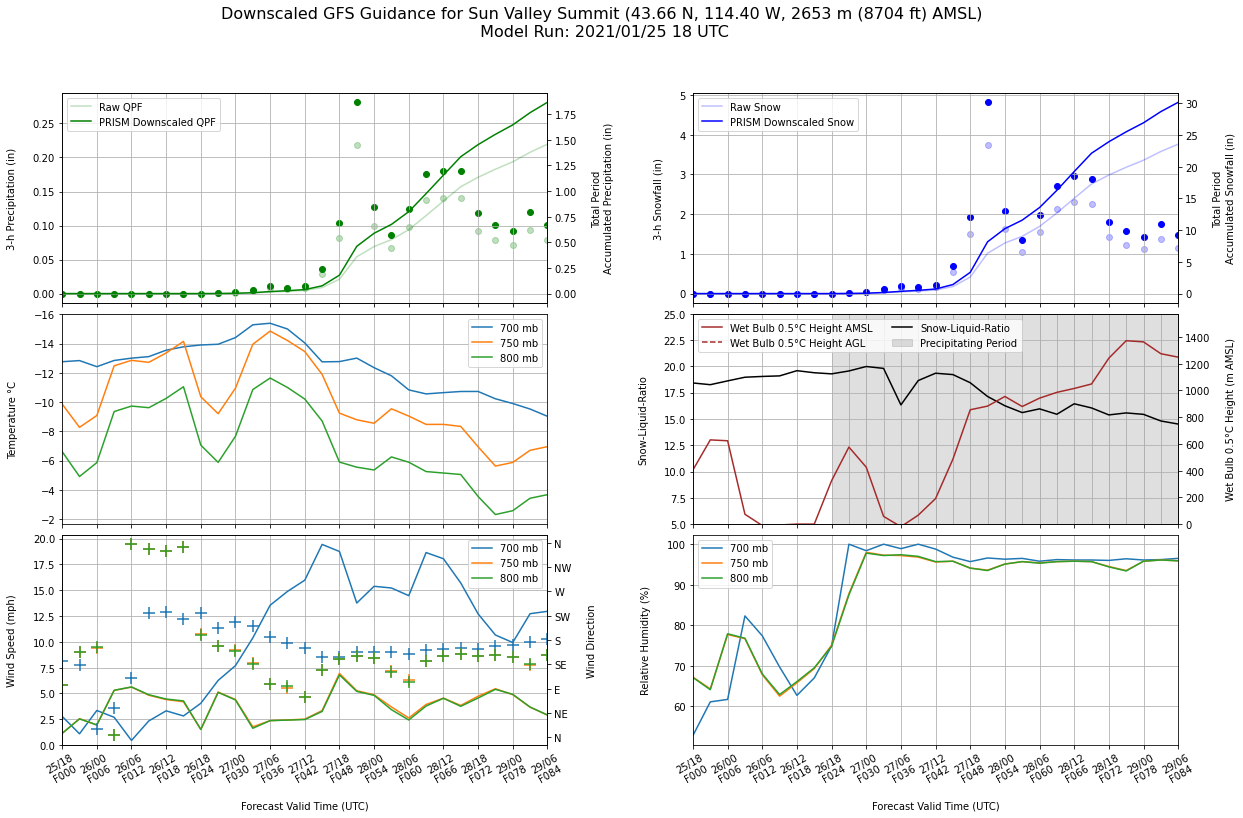

In [22]:
plt.rcParams.update({'font.size': 10})

fig, axs = plt.subplots(3, 2, figsize=(20, 12), facecolor='w')
axs = axs.flatten()
fig.subplots_adjust(wspace=0.3, hspace=0.05)

aux0 = axs[0].twinx()
axs[0].scatter(np.arange(0, len(fhrs)), data_ds['qpf'], color='g', alpha=.25)
axs[0].scatter(np.arange(0, len(fhrs)), data_ds['dqpf'], color='g', alpha=1.0)
axs[0].set_ylabel('3-h Precipitation (in)\n')
aux0.plot(data_ds['qpf'].cumsum(), color='g', alpha=.25, label='Raw QPF')
aux0.plot(data_ds['dqpf'].cumsum(), color='g', alpha=1.0, label='PRISM Downscaled QPF')
aux0.legend(loc='upper left')
aux0.set_ylabel('\nTotal Period\nAccumulated Precipitation (in)')

aux1 = axs[1].twinx()
axs[1].scatter(np.arange(0, len(fhrs)), data_ds['qsf'], color='b', alpha=.25)
axs[1].scatter(np.arange(0, len(fhrs)), data_ds['dqsf'], color='b', alpha=1.0)
axs[1].set_ylabel('3-h Snowfall (in)\n')
aux1.plot(data_ds['qsf'].cumsum(), color='b', alpha=.25, label='Raw Snow')
aux1.plot(data_ds['dqsf'].cumsum(), color='b', alpha=1.0, label='PRISM Downscaled Snow')
aux1.set_ylabel('\nTotal Period\nAccumulated Snowfall (in)')

axs[3].plot(data_ds['slr'], color='k')
axs[3].set_yticks(np.arange(5, 26, 2.5))
axs[3].set_ylabel('Snow-Liquid-Ratio\n')
aux3 = axs[3].twinx()
aux3.axvspan(0, 0, color='gray', alpha=0.25, label='Precipitating Period')
aux3.plot(data_ds['wbzh'], color='brown', label='Wet Bulb 0.5°C Height AMSL')
aux3.plot(data_ds['wbzh']-siteelev, color='brown', linestyle='--', label='Wet Bulb 0.5°C Height AGL')
aux3.set_ylim(bottom=0)
aux3.set_ylabel('\nWet Bulb 0.5°C Height (m AMSL)')
[axs[3].axvspan(pp-1, pp, color='gray', alpha=0.25) 
 for pp in np.where(data_raw['qpf'] > 0.01)[0]]
aux3.plot(0, 0, color='k', label='Snow-Liquid-Ratio')

# axs[2].plot(data_raw['t'].sel(level=500)-273.15, label='500 mb')
axs[2].plot(data_raw['t'].sel(level=700)-273.15, label='700 mb')
axs[2].plot(data_raw['t'].sel(level=750)-273.15, label='750 mb')
axs[2].plot(data_raw['t'].sel(level=800)-273.15, label='800 mb')
axs[2].set_ylim(axs[2].get_ylim()[::-1])
axs[2].axhline(0, color='k', linestyle='--', linewidth=1)
axs[2].set_ylabel('Temperature °C\n')

u, v = data_raw['u'], data_raw['v']
wspd = np.sqrt(u**2 + v**2)/0.44704
wdir = 90 - np.degrees(np.arctan2(-v, -u))
wdir = xr.where(wdir <= 0, wdir+360, wdir)
wdir = xr.where(((u == 0) & (v == 0)), 0, wdir)

aux4 = axs[4].twinx()
# aux4.scatter(np.arange(0, len(fhrs)), wdir.sel(level=500), marker='+', s=150, label='500 mb')
aux4.scatter(np.arange(0, len(fhrs)), wdir.sel(level=700), marker='+', s=150, label='700 mb')
aux4.scatter(np.arange(0, len(fhrs)), wdir.sel(level=750), marker='+', s=150, label='750 mb')
aux4.scatter(np.arange(0, len(fhrs)), wdir.sel(level=800), marker='+', s=150, label='800 mb')
aux4.set_yticks(np.arange(0, 361, 45))
aux4.set_yticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N'])
aux4.set_ylabel('\nWind Direction')

# axs[4].plot(wspd.sel(level=500), label='500 mb')
axs[4].plot(wspd.sel(level=700), label='700 mb')
axs[4].plot(wspd.sel(level=750), label='750 mb')
axs[4].plot(wspd.sel(level=850), label='800 mb')
axs[4].set_ylim(bottom=0)
axs[4].set_ylabel('Wind Speed (mph)\n')

# axs[5].plot(data_raw['r'].sel(level=500), label='500 mb')
axs[5].plot(data_raw['r'].sel(level=700), label='700 mb')
axs[5].plot(data_raw['r'].sel(level=750), label='750 mb')
axs[5].plot(data_raw['r'].sel(level=800), label='800 mb')

axs[5].set_ylabel('Relative Humidity (%)\n')

xskip = 2
for ax in axs:
    ax.grid()
    ax.set_xlim([0, len(fhrs)-1])
    ax.set_xticks(np.arange(0, len(fhrs))[::xskip])
    ax.set_xticklabels([])
    
for ax in [aux0, aux1, axs[2], axs[4], axs[5]]:
    ax.legend()
    ax.set_xticklabels([])
    
aux3.legend(ncol=2)

dates = [pd.to_datetime(d).strftime('%Y/%m/%d %H UTC') for d in data_raw.time.values]
xdates = [pd.to_datetime(d).strftime('%d/%H') + '\nF%03d'%fhr for d, fhr in zip(data_raw.time.values, fhrs)]
for ax in [axs[4], axs[5]]:
    ax.set_xlabel('\nForecast Valid Time (UTC)')
    ax.set_xticklabels(xdates[::xskip], rotation=30)
    
plt.suptitle('Downscaled GFS Guidance for {} ({:.2f} N, {:.2f} W, {:.0f} m ({:.0f} ft) AMSL)\n Model Run: {}'.format(
    site, site_meta[site]['lat'], abs(site_meta[site]['lon']), siteelev, siteelev*3.28084,
    init.strftime('%Y/%m/%d %H UTC')), 
             fontsize=16)

plt.show()